In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet201  # Modified to DenseNet201
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import cv2

# CLAHE Preprocessing Function for RGB
def clahe_preprocessing(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = [clahe.apply(image[:, :, i].astype(np.uint8)) for i in range(3)]
    clahe_image = np.stack(channels, axis=-1)
    return clahe_image.astype(np.float32) / 255.0  # Rescale to 0-1 after CLAHE

def adjust_contrast(image):
    contrast_factor = np.random.uniform(0.8, 1.2)  # Random contrast adjustment
    return tf.image.adjust_contrast(image, contrast_factor)

# Wrap custom preprocessing for ImageDataGenerator
def custom_preprocessing(image):
    image = clahe_preprocessing(image)  # Apply CLAHE
    image = adjust_contrast(image)      # Adjust contrast randomly
    return image

# Data Preparation Paths
dataset_dir = r'D:\3rd sem Project\Secondary dataset\chest_xray'
train_dir = dataset_dir + '\\train'
test_dir = dataset_dir + '\\test'

# ImageDataGenerator for Training with CLAHE, Custom Augmentations, and Transformations
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,  # Apply CLAHE, noise, and contrast adjustment
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# ImageDataGenerator for Test Data with Only Rescaling
test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocessing)

# Instantiate Train and Test Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # No shuffling for validation/testing data
)

# Model Architecture
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Load DenseNet201 base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze DenseNet layers if desired
for layer in base_model.layers:
    layer.trainable = False

# Feature extraction using DenseNet
x = base_model(inputs)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Primary Capsule Layer
class PrimaryCaps(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(filters=self.num_capsules * self.dim_capsules,
                                           kernel_size=3,
                                           strides=1,
                                           padding='same')
        super(PrimaryCaps, self).build(input_shape)

    def call(self, inputs):
        output = self.conv(inputs)
        output = tf.reshape(output, (-1, output.shape[1] * output.shape[2] * self.num_capsules, self.dim_capsules))
        return self.squash(output)

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s

    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_capsules': self.num_capsules,
            'dim_capsules': self.dim_capsules
        })
        return config

# Capsule Layer
class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsules],
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        inputs_hat = tf.einsum('bij,jk->bik', inputs, self.W)
        inputs_hat = tf.reshape(inputs_hat, (-1, inputs.shape[1], self.num_capsules, self.dim_capsules))
        b = tf.zeros_like(inputs_hat[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = self.squash(tf.reduce_sum(c[:, :, :, tf.newaxis] * inputs_hat, axis=1))
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs[:, tf.newaxis, :, :], axis=-1)
        return outputs

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s

    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_capsules': self.num_capsules,
            'dim_capsules': self.dim_capsules,
            'routings': self.routings
        })
        return config

# Apply Primary Capsule Layer and Capsule Layer
primary_caps = PrimaryCaps(num_capsules=64, dim_capsules=16)(x)
capsule = CapsuleLayer(num_capsules=10, dim_capsules=32, routings=4)(primary_caps)

# Flatten and Output Layers
flat = Flatten()(capsule)
dense = Dense(512, activation='relu')(flat)
dropout = Dropout(0.6)(dense)
outputs = Dense(1, activation='sigmoid')(dropout)

# Build the Model
model = Model(inputs, outputs)
model.summary()  # Display model summary

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         4423936   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                             
                                                                 
 primary_caps_1 (PrimaryCaps  (None, 576, 16)          2360320   
 )                                                               
                                          

In [12]:
# Compile the Model with Adam Optimizer and Binary Cross-Entropy Loss
model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

# Define Callbacks
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-6)
callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the Model
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=callbacks
)

# Save the Trained Model
model.save('CNN_final_model.h5')

Epoch 1/50
326/326 [==============================] - 126s 355ms/step - loss: 0.1766 - accuracy: 0.9323 - val_loss: 0.2929 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 2/50
326/326 [==============================] - 119s 365ms/step - loss: 0.1502 - accuracy: 0.9434 - val_loss: 0.2427 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 3/50
326/326 [==============================] - 114s 349ms/step - loss: 0.1626 - accuracy: 0.9381 - val_loss: 0.3067 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 4/50
326/326 [==============================] - 118s 364ms/step - loss: 0.1335 - accuracy: 0.9507 - val_loss: 0.2735 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 5/50
326/326 [==============================] - 122s 375ms/step - loss: 0.1256 - accuracy: 0.9536 - val_loss: 0.3434 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 6/50
326/326 [==============================] - 123s 377ms/step - loss: 0.1229 - accuracy: 0.9551 - val_loss: 0.2159 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 7/50
326/326 [==========================

39/39 [==============================] - 8s 125ms/step


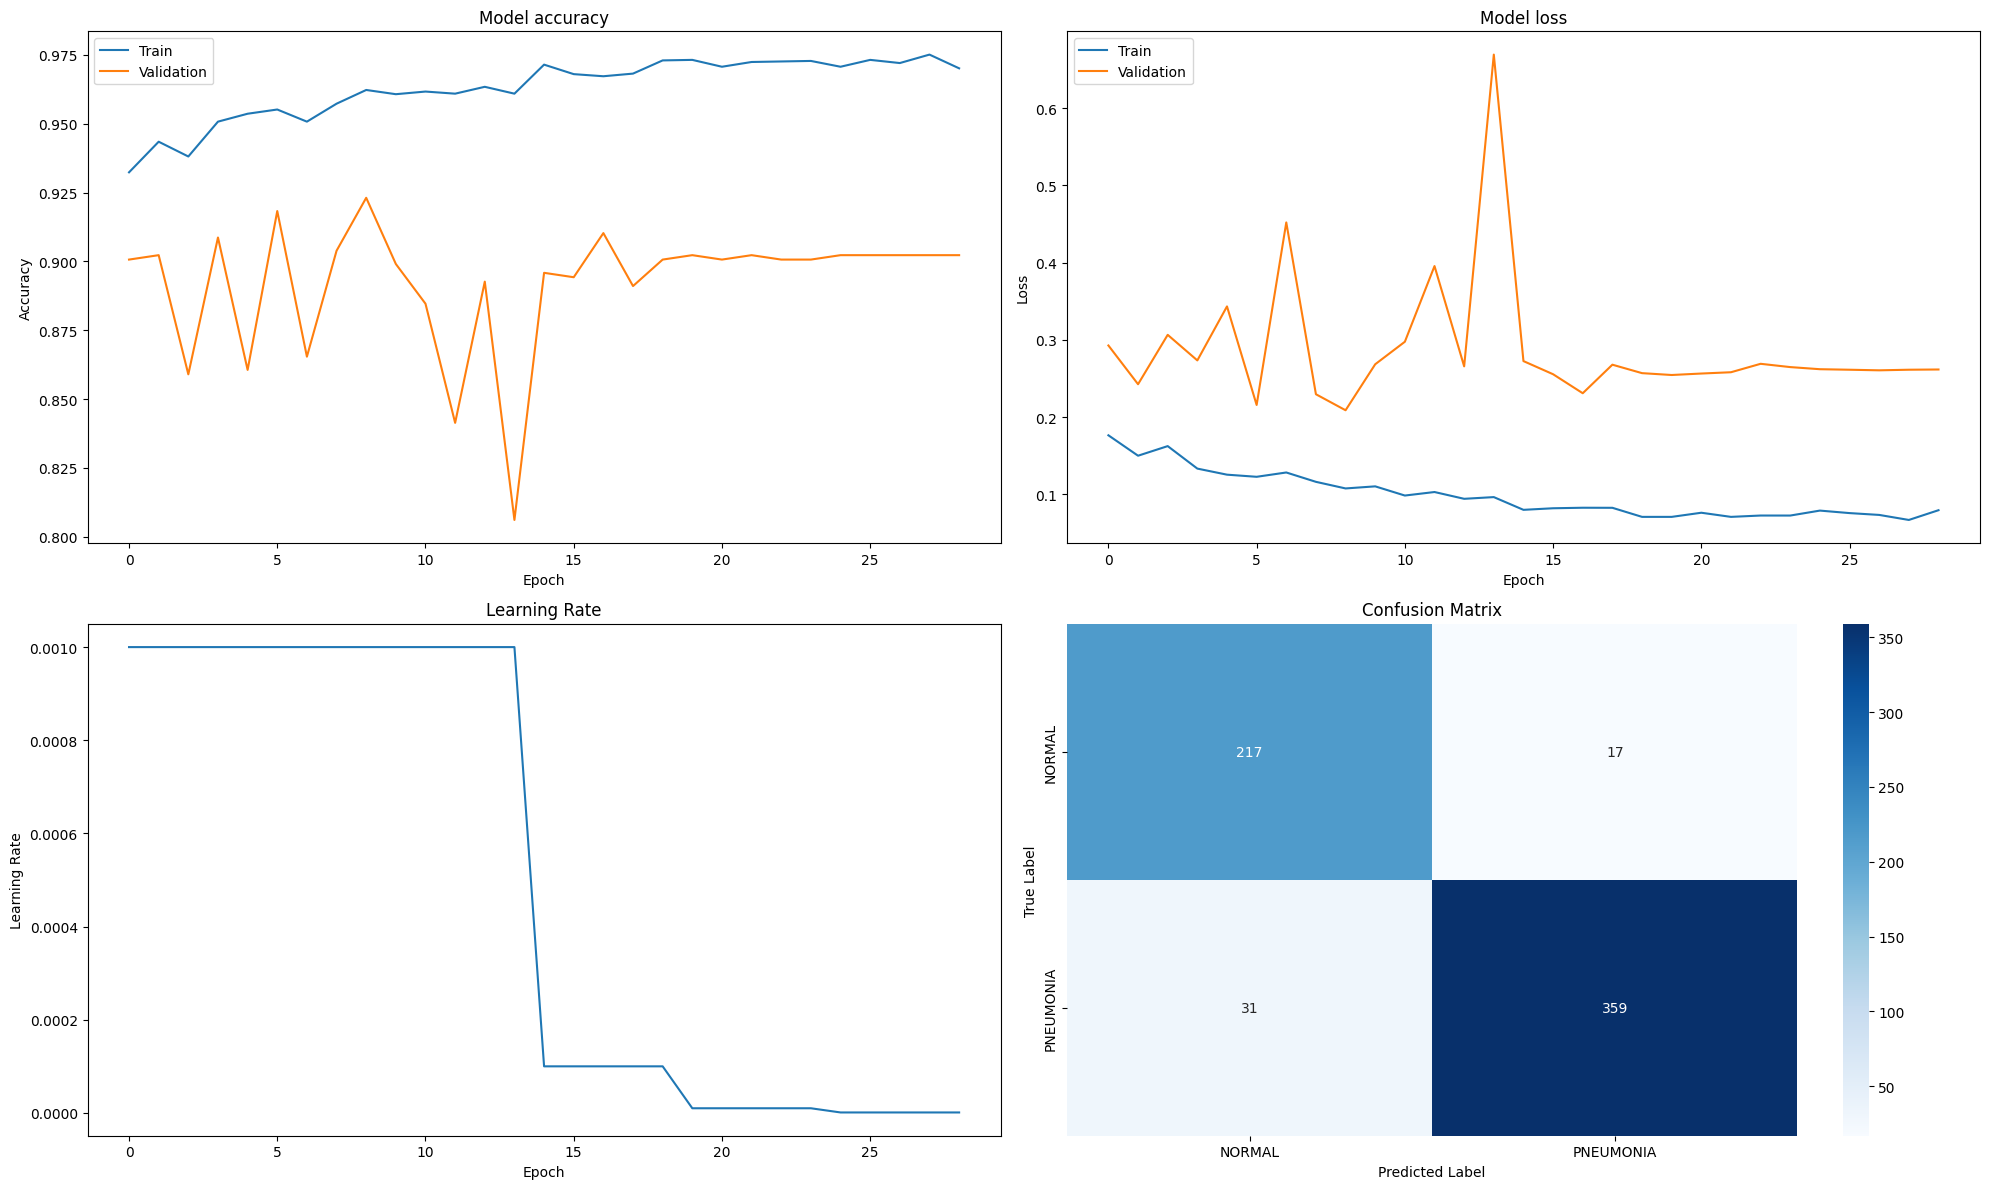

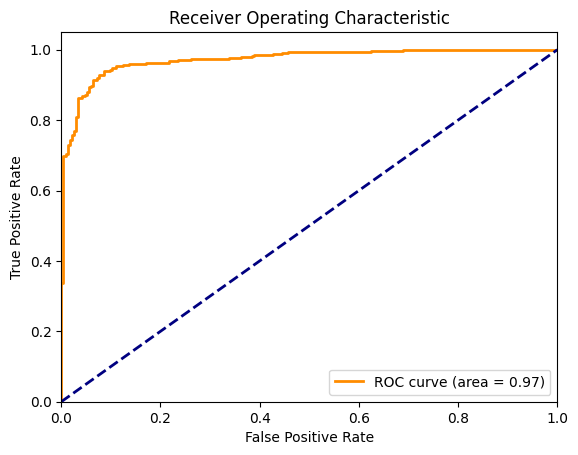

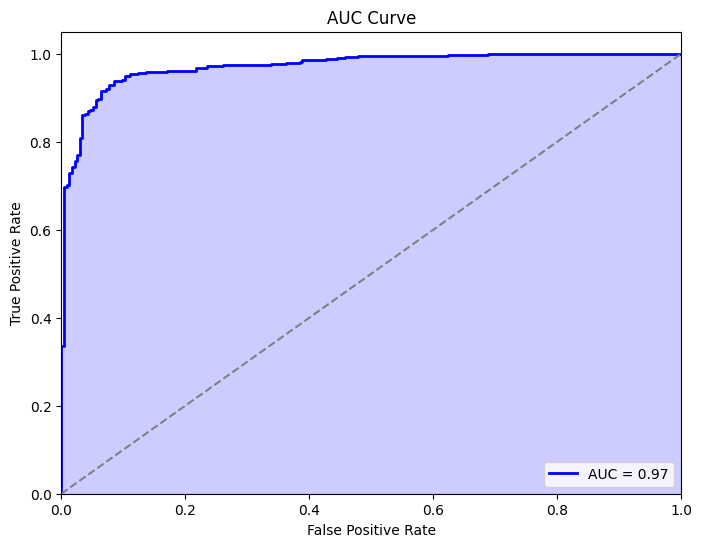

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

def plot_training_history(history, model, test_generator):
    # Plot training & validation accuracy values
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot learning rate
    if 'lr' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')
    
    # Confusion Matrix
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())   
    
    plt.subplot(2, 2, 4)
    cm = confusion_matrix(true_classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(true_classes, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Plot AUC as an additional metric
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
    plt.fill_between(fpr, tpr, alpha=0.2, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
plot_training_history(history, model, test_generator)

Found 72 images belonging to 2 classes.
72/72 [==============================] - 8s 47ms/step
Validation Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        36
   PNEUMONIA       1.00      1.00      1.00        36

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



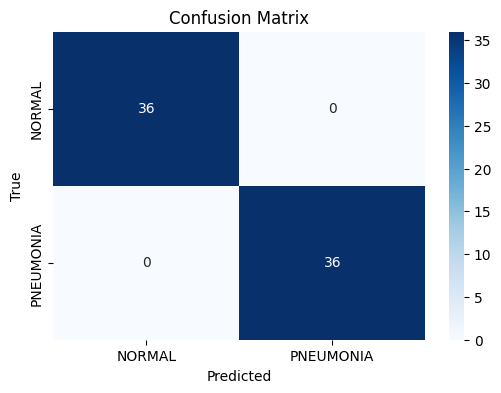

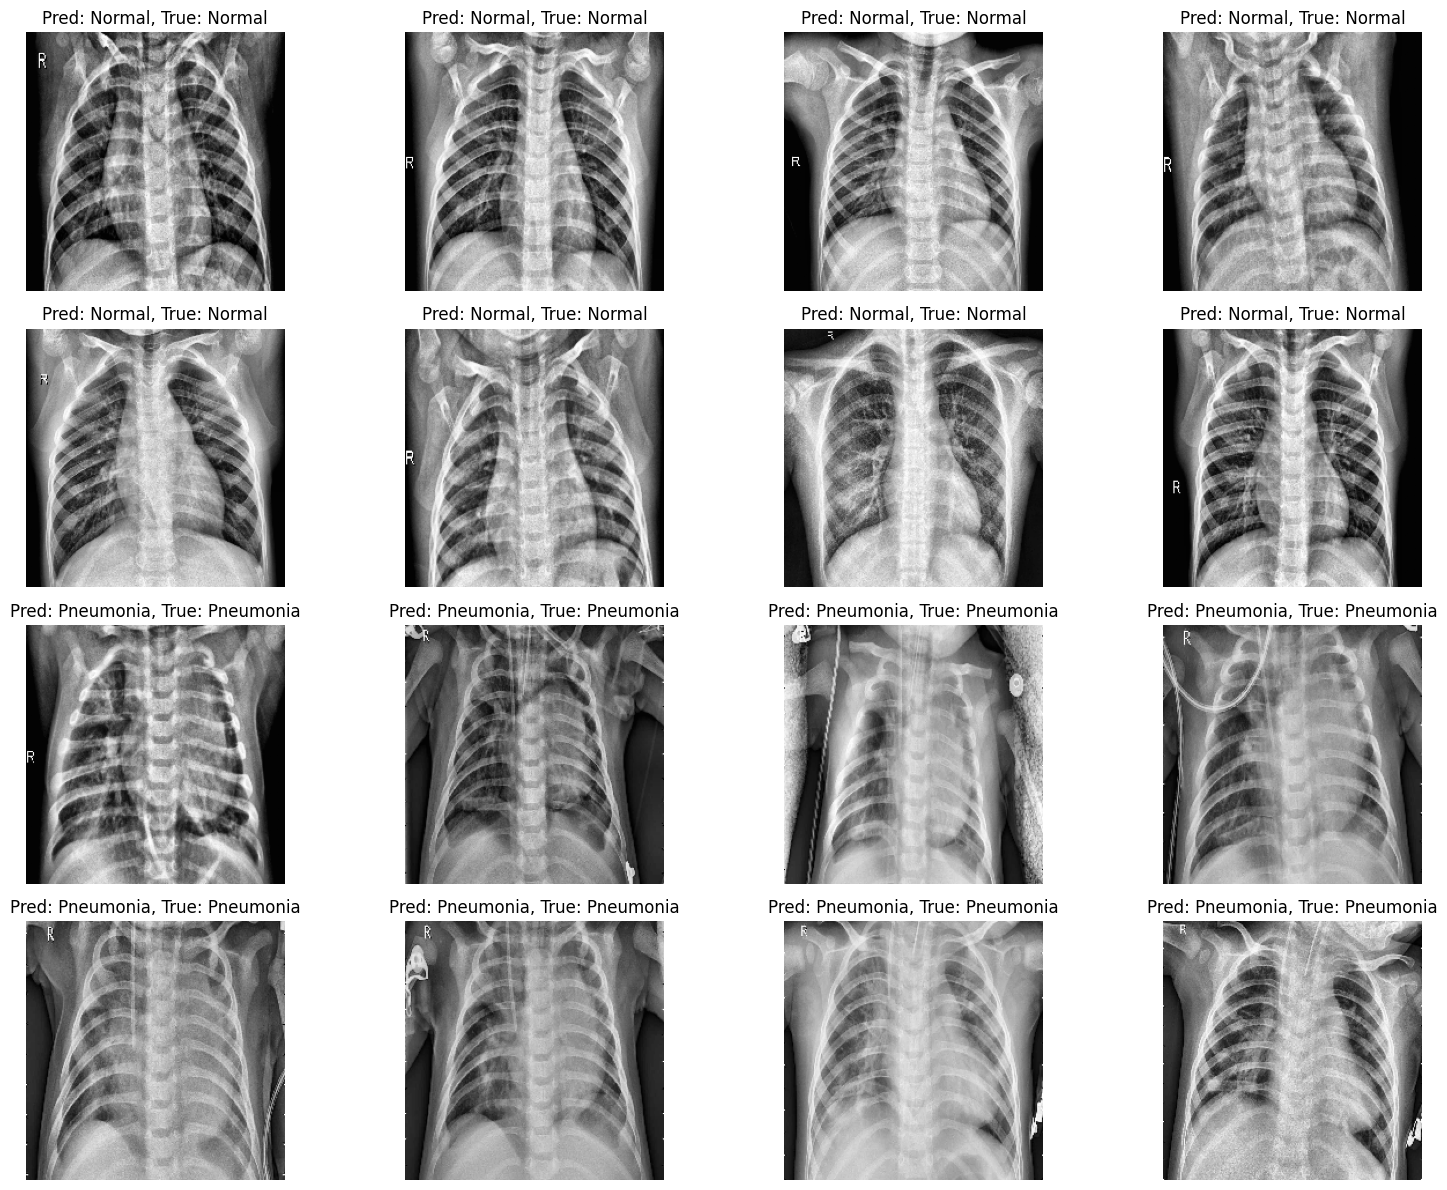

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import cv2

# Load the trained model
model = load_model('CNN_final_model.h5', custom_objects={'PrimaryCaps': PrimaryCaps, 'CapsuleLayer': CapsuleLayer})

# Directory for validation data
val_dir = r'D:\3rd sem Project\Secondary dataset\chest_xray\val'

# CLAHE Preprocessing Function for RGB
def clahe_preprocessing(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = [clahe.apply(image[:, :, i].astype(np.uint8)) for i in range(3)]
    clahe_image = np.stack(channels, axis=-1)
    return clahe_image.astype(np.float32) / 255.0  # Rescale to 0-1 after CLAHE

# ImageDataGenerator for validation
val_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocessing)

# Prepare validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Match input size of DenseNet201
    batch_size=1,            # Use batch_size=1 for individual predictions
    class_mode='binary',
    shuffle=False             # Disable shuffling for consistent ordering
)

# Get class labels
class_indices = val_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Predict on validation data
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels.values()))

# Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prepare lists to store images from each class
normal_images = []
pneumonia_images = []

# Retrieve images from both classes for visualization
for i in range(len(y_true)):
    img, label = val_generator.next()
    img = img[0]  # Extract single image from batch
    
    # Separate images by class
    if y_true[i] == 0 and len(normal_images) < 8:
        normal_images.append((img, 'Normal', 'Pneumonia' if y_pred[i] == 1 else 'Normal'))
    elif y_true[i] == 1 and len(pneumonia_images) < 8:
        pneumonia_images.append((img, 'Pneumonia', 'Pneumonia' if y_pred[i] == 1 else 'Normal'))
    
    # Stop once we have 8 images from each class
    if len(normal_images) >= 8 and len(pneumonia_images) >= 8:
        break

# Combine and visualize the selected images
selected_images = normal_images + pneumonia_images
plt.figure(figsize=(16, 12))
for i, (img, true_label, pred_label) in enumerate(selected_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

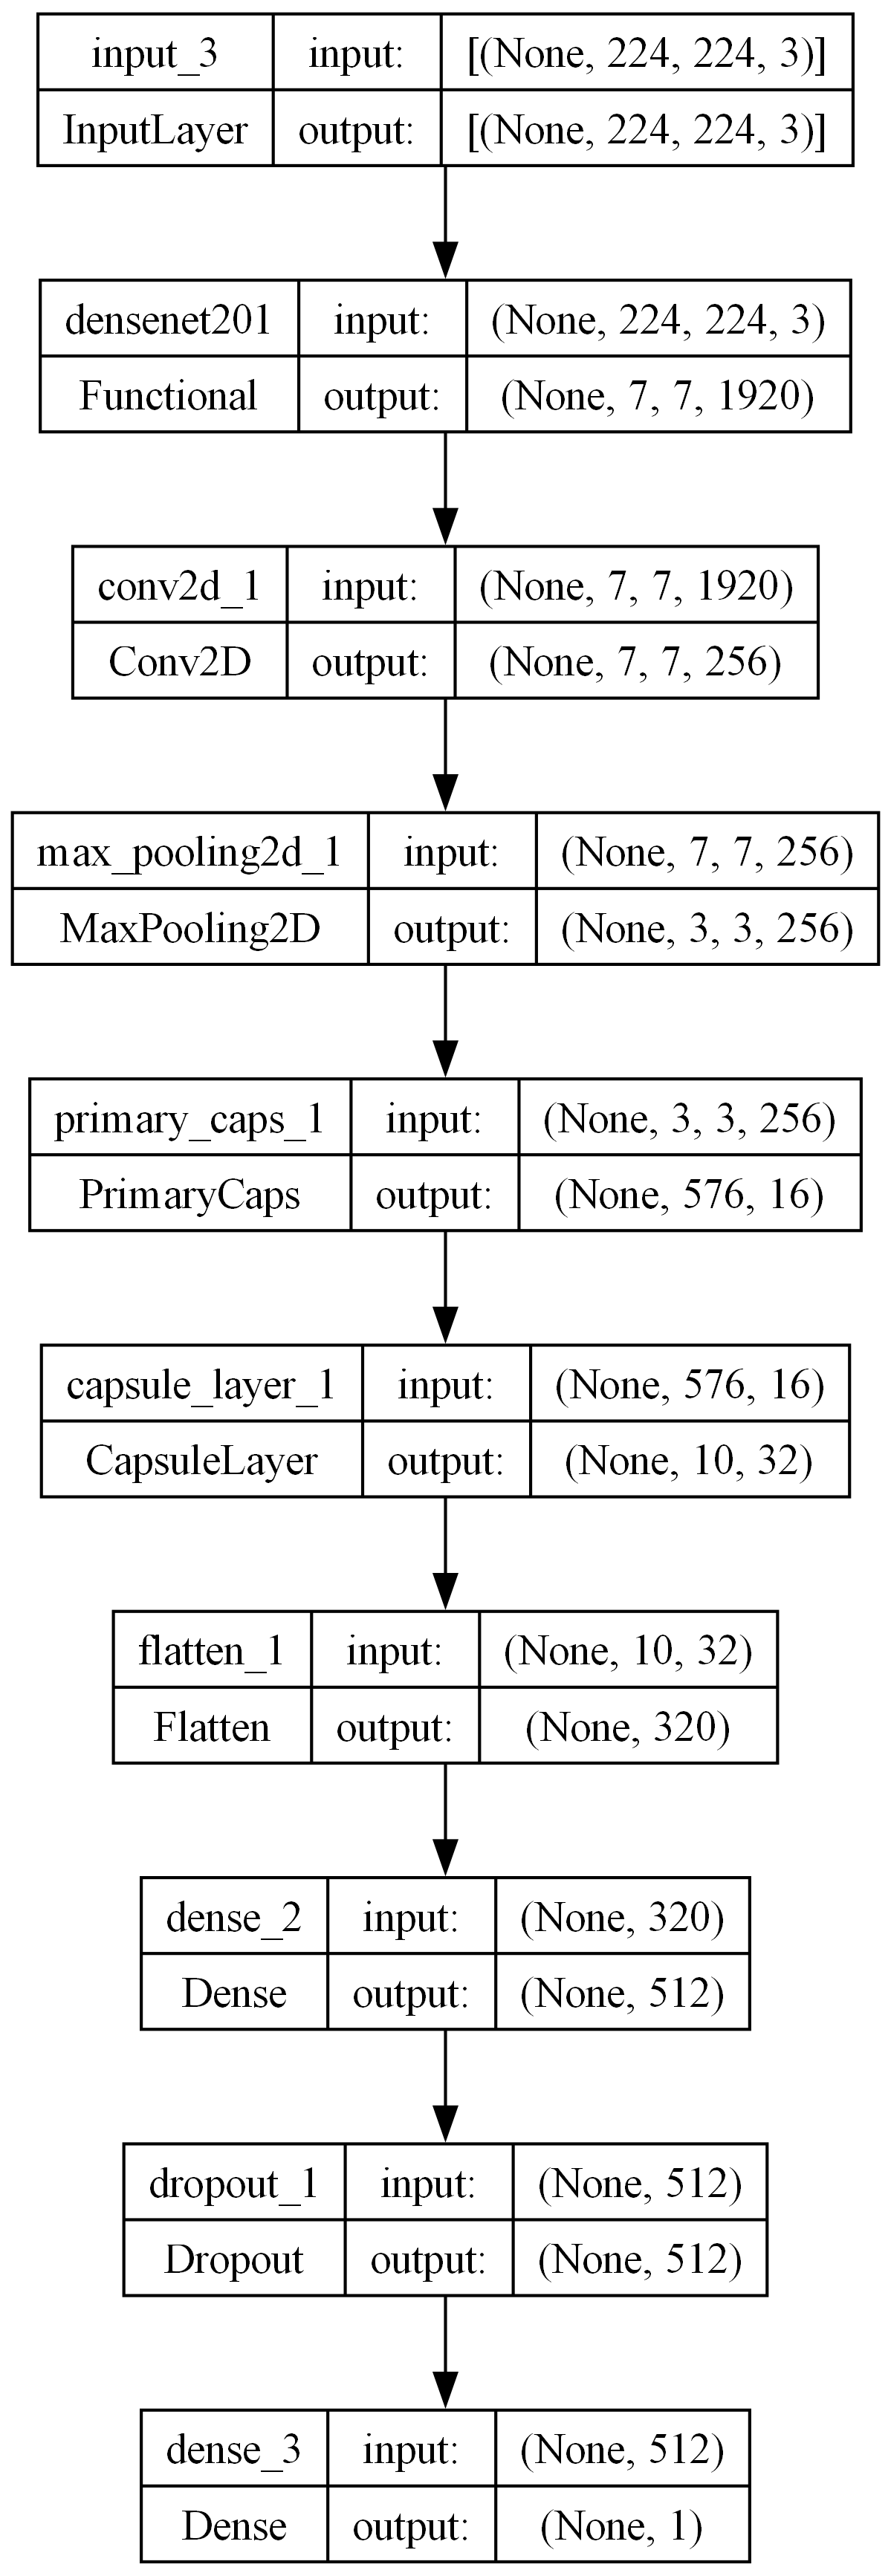

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Primary Capsule Layer
class PrimaryCaps(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(filters=self.num_capsules * self.dim_capsules,
                                           kernel_size=3,
                                           strides=1,
                                           padding='same')
        super(PrimaryCaps, self).build(input_shape)

    def call(self, inputs):
        output = self.conv(inputs)
        output = tf.reshape(output, (-1, output.shape[1] * output.shape[2] * self.num_capsules, self.dim_capsules))
        return self.squash(output)

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s

    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_capsules': self.num_capsules,
            'dim_capsules': self.dim_capsules
        })
        return config

# Capsule Layer
class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsules],
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        inputs_hat = tf.einsum('bij,jk->bik', inputs, self.W)
        inputs_hat = tf.reshape(inputs_hat, (-1, inputs.shape[1], self.num_capsules, self.dim_capsules))
        b = tf.zeros_like(inputs_hat[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = self.squash(tf.reduce_sum(c[:, :, :, tf.newaxis] * inputs_hat, axis=1))
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs[:, tf.newaxis, :, :], axis=-1)
        return outputs

    def squash(self, s):
        s_squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s

    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_capsules': self.num_capsules,
            'dim_capsules': self.dim_capsules,
            'routings': self.routings
        })
        return config

# Load the trained model
model = load_model('CNN_final_model.h5', custom_objects={'PrimaryCaps': PrimaryCaps, 'CapsuleLayer': CapsuleLayer})

# Plot the model architecture with increased resolution
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=300)  # Set DPI to 300 for higher resolution